In [120]:
# import packages
import numpy as np

In [215]:
class Beam:
    def __init__(self, theta_init, delta_s, EI, MA, Mag_Field) -> None:
        # theta: angle of each segment, shape [N]
        self.theta = np.array(theta_init)

        # delta_s: length of each segment, shape [N]
        self.delta_s = np.array(delta_s) * np.ones(self.theta.shape)
        self.update_location()

        # EI, MA: material properties of the beam, shape[N]
        self.EI = EI
        self.MA = MA

        # Defines the mag field and its spacial gradient
        self.Mag_Field = Mag_Field
        assert(hasattr(Mag_Field, 'B') and hasattr(Mag_Field, 'dBdX'))
        self.B = Mag_Field.B
        self.dBdX = Mag_Field.dBdX

        return
    
    def update_location(self, theta=None):
        self.n = self.cal_n(theta)
        self.X = self.cal_X()
        self.dXdTheta = self.cal_dXdTheta()

    # n: tangent vector of each segment, shape [N, dim=2]
    def cal_n(self, theta=None) -> np.ndarray:
        if theta is None:
            theta = self.theta
        return np.stack([np.cos(theta), np.sin(theta)], axis=1)

    # X: location of end of each segment, shape [N, dim=2]
    def cal_X(self, theta=None) -> np.ndarray:
        if theta is None:
            n = self.n
        else:
            n = self.cal_n(theta)
        X = self.delta_s.reshape([-1, 1]) * n
        X = np.cumsum(X, axis=0)
        return X

    # dXdtheta: grad of X w.r.t. theta, shape [N, dim=2, N]
    def cal_dXdTheta(self, theta=None) -> np.ndarray:
        if theta is None:
            theta = self.theta
            X = self.X
        else:
            X = self.cal_X(theta)

        dXdTheta = np.zeros([X.shape[0], X.shape[1], X.shape[0]])
        
        # dx/dtheta
        dXdTheta[:, 0, :] = np.tril(np.repeat((-self.delta_s * np.sin(theta)).reshape([1, -1]), X.shape[0], axis=0), 0)
        dXdTheta[:, 1, :] = np.tril(np.repeat(( self.delta_s * np.cos(theta)).reshape([1, -1]), X.shape[0], axis=0), 0)

        return dXdTheta
        
    # Broadcast B(X) : \mathbb{R}^d to \mathbb{R}^d to all N grid points (thetas), return size (N, d)
    # B(x, y) : function taking in X = [x, y] and return a vector [Bx, By]
    def broadcast_B(self, B=None, theta=None) -> np.ndarray:
        if theta is None:
            X = self.X
        else:
            X = self.cal_X(theta)
        if B is None:
            B = self.B
        res = np.moveaxis(B(X), -1, 0)
        return res
    
    # Broadcast dBdTheta(X) : \mathbb{R}^d to (\mathbb{R}^d)^2
    #  to all N grid points (thetas), return size (N, d, N)
    # dBdTheta(x, y) : function taking in X = [x, y] and return a tensor [[Bxx, Bxy], [Byx, Byy]]
    def broadcast_dBdTheta(self, dBdX=None, theta=None) -> np.ndarray:
        if theta is None:
            dXdTheta = self.dXdTheta
            X = self.X
        else:
            dXdTheta = self.cal_dXdTheta(theta)
            X = self.cal_X(theta)

        if dBdX is None:
            dBdX = self.dBdX
        dBdX_tmp = np.moveaxis(dBdX(X), -1, 0)

        return np.matmul(dBdX_tmp, dXdTheta)


    # Calculate total potential energy Pi(theta)
    def cal_Pi(self, theta=None) -> np.float64: 
        Mag_B = self.broadcast_B(theta=theta)
        if theta is None:
            theta = self.theta
            n = self.n
        else:
            n = self.cal_n(theta)
        
        # Bending potential
        bending_Pi = np.sum(
            self.EI / (2. * self.delta_s) * (np.diff(theta, prepend=0.) ** 2)
        )

        # Magnetic potential
        mag_Pi = -np.sum(
            self.MA * self.delta_s * np.sum(Mag_B * n, axis=1)
        )

        return bending_Pi + mag_Pi
    
    # Calculate dPidTheta
    def cal_dPidTheta(self, theta=None) -> np.ndarray:
        Mag_B = self.broadcast_B(theta=theta)
        n = self.cal_n(theta)
        Mag_dBdTheta = self.broadcast_dBdTheta(theta=theta)

        if theta is None:
            theta = self.theta
        
        # Bending terms
        bending_dPidTheta = self.EI / self.delta_s * (np.diff(theta, prepend=0.))
        bending_dPidTheta = -np.diff(bending_dPidTheta, append=0.)

        # Mag terms
        dndTheta = np.stack([-np.sin(theta), np.cos(theta)], axis=1)
        mag_dPidTheta_1 = -self.MA * self.delta_s * np.sum(Mag_B * dndTheta, axis=1)
        N = n.shape[0]
        mag_dPidTheta_2 = -np.sum(
            (self.MA * self.delta_s).reshape([N, -1]) * \
                np.sum(Mag_dBdTheta * np.stack([n for i in range(N)], axis=2), axis=1), 
            axis=0, 
        )

        return bending_dPidTheta + mag_dPidTheta_1 + mag_dPidTheta_2

    # Plot beam
    def plot_current_position(self, theta=None) -> tuple:
        # Plot current configuration
        from matplotlib import pyplot as plt
        from matplotlib import rc

        # Set up fonts
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        ## for Palatino and other serif fonts use:
        #rc('font',**{'family':'serif','serif':['Palatino']})
        rc('text', usetex=True)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fsize = 20

        # Plot the beam
        if not (theta is None):
            self.update_location(theta)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[10, 10])
        ax.plot(self.X[:, 0], self.X[:, 1], linewidth=2.0)
        ax.scatter(self.X[:, 0], self.X[:, 1])
        ax.set_xlabel("$x / L$", fontsize=fsize)
        ax.set_ylabel("$y / L$", fontsize=fsize)
        ax.set_title("Deflection of beam under $\\textbf{B}(x, y)$", fontsize=fsize)
        ax.tick_params(axis='both', which='major', labelsize=fsize)

        # Plot the Magnetic field
        X = np.linspace(-1., 1., 11)
        Y = np.linspace(-1., 1., 11)
        XX, YY, BXX, BYY = self.Mag_Field.compute_B_over_grid(X, Y)
        Q = ax.quiver(XX, YY, BXX, BYY, label="shit")
        ax.quiverkey(Q, X=0.7, Y=0.92, U=1, label='$\|\\textbf{B}\| = 1$', labelpos='E', fontproperties={'size': fsize})
        fig.show()

        return fig, ax

In [225]:
"""
Class MagneticField, defines:
    - B : \mathrm{R}^dim -> \mathrm{R}^dim
    - dBdX: \mathrm{R}^dim -> \mathrm{R}^dim x \mathrm{R}^dim
"""
class MagneticField:
    def __init__(self, B, dBdX) -> None:
        self.B = B
        self.dBdX = dBdX
        return
    
    # Compute B over a grid defined by X, Y
    def compute_B_over_grid(self, X, Y) -> tuple:
        XX, YY = np.meshgrid(X, Y)
        Z = self.B(
            np.stack([XX.reshape([-1]), YY.reshape([-1])], axis=1)
        )

        BXX = Z[0, :].reshape(XX.shape)
        BYY = Z[1, :].reshape(XX.shape)
        
        return XX, YY, BXX, BYY

# ---------------------------------------------- #
#     Magnetic field with zero gradient          #
# ---------------------------------------------- #
def uniform_B(X) -> np.ndarray:
    N = X.shape[0]
    # res = np.array([-0.36 * np.ones(N), 0.72 * np.ones(N)])
    res = np.array([0.* np.ones(N), 1. * np.ones(N)])
    return res

# X shape: [N, dim], return shape: [dim, dim, N]
def zero_dBdX(X) -> np.ndarray:
    N = X.shape[0]
    res = np.array([[   0. * np.zeros(N),   0. * np.zeros(N)], 
                    [   0. * np.zeros(N),   0. * np.zeros(N)]])
    return res

# ---------------------------------------------- #
#     Magnetic field with uniform gradient       #
# ---------------------------------------------- #
def linear_B(X) -> np.ndarray:
    res = np.array([-0.36 * (X[:, 0] + 1.), 0.72 * (X[:, 1] + 1.)])
    return res

# X shape: [N, dim], return shape: [dim, dim, N]
def uniform_dBdX(X) -> np.ndarray:
    N = X.shape[0]
    res = np.array([[-0.36 * np.ones(N),   0. * np.ones(N)], 
                    [   0. * np.ones(N), 0.72 * np.ones(N)]])
    return res


<ipython-input-215-27b8d4fc7390>:167: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Deflection of beam under $\\textbf{B}(x, y)$'}, xlabel='$x / L$', ylabel='$y / L$'>)

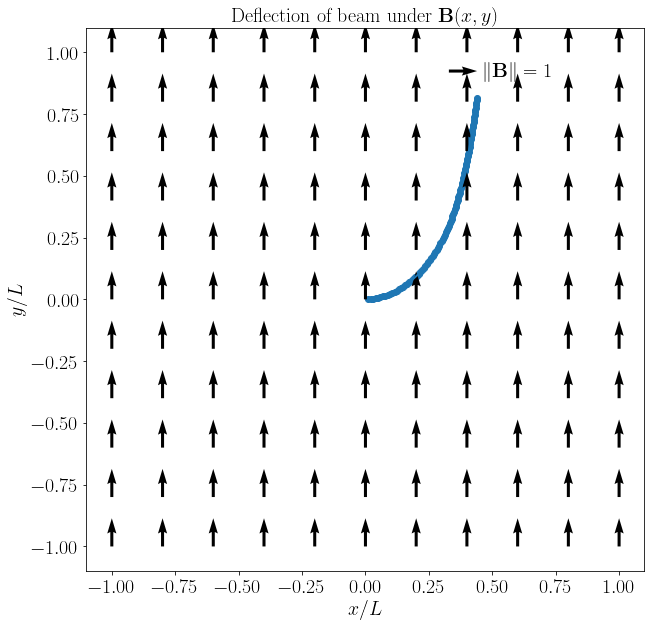

In [226]:
# Beam under uniform B
uniformMagField = MagneticField(uniform_B, zero_dBdX)

# Parameters for the beam
N = 100 # Number of intervals
total_length = 1. # Length of the beam
params = {
    "theta_init" : np.zeros(N), 
    "delta_s" : total_length / N, 
    "EI" : 0.1 * np.ones(N), 
    "MA" : np.ones(N), 
    "Mag_Field" : uniformMagField, 
}
uniformB_Beam = Beam(**params)

# Use scipy minimize for solving beam configuration
from scipy.optimize import minimize
sol = minimize(uniformB_Beam.cal_Pi, 
               x0=uniformB_Beam.theta, 
               method='BFGS', 
               jac=uniformB_Beam.cal_dPidTheta, 
               tol=1.e-8)
uniformB_Beam.update_location(theta=sol.x)
uniformB_Beam.plot_current_position()

<ipython-input-215-27b8d4fc7390>:167: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Deflection of beam under $\\textbf{B}(x, y)$'}, xlabel='$x / L$', ylabel='$y / L$'>)

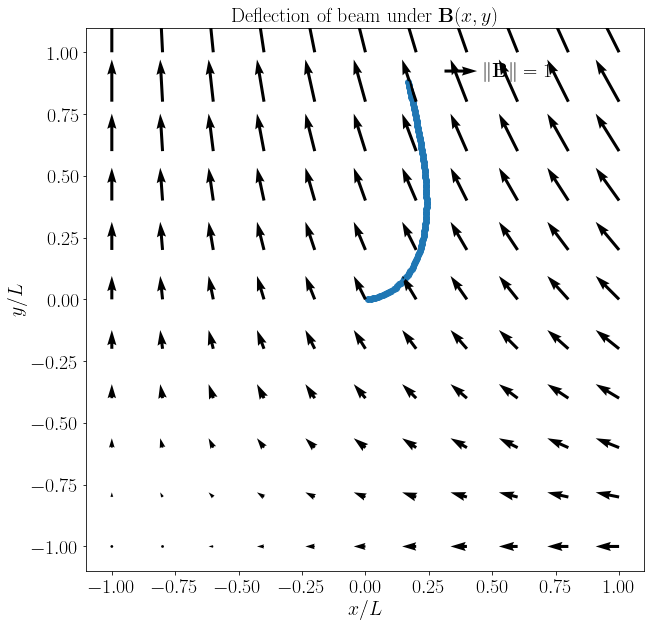

In [227]:
# Beam under uniform_Grad B
uniformGradMagField = MagneticField(linear_B, uniform_dBdX)

# Parameters for the beam
N = 100 # Number of intervals
total_length = 1. # Length of the beam
params = {
    "theta_init" : np.zeros(N), 
    "delta_s" : total_length / N, 
    "EI" : 0.1 * np.ones(N), 
    "MA" : np.ones(N), 
    "Mag_Field" : uniformGradMagField, 
}
uniformGradB_Beam = Beam(**params)

# Use scipy minimize for solving beam configuration
from scipy.optimize import minimize
sol = minimize(uniformGradB_Beam.cal_Pi, 
               x0=uniformGradB_Beam.theta, 
               method='BFGS', 
               jac=uniformGradB_Beam.cal_dPidTheta, 
               tol=1.e-8)
uniformGradB_Beam.update_location(theta=sol.x)
uniformGradB_Beam.plot_current_position()

# Trial plots

<ipython-input-214-c25b3171dd90>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


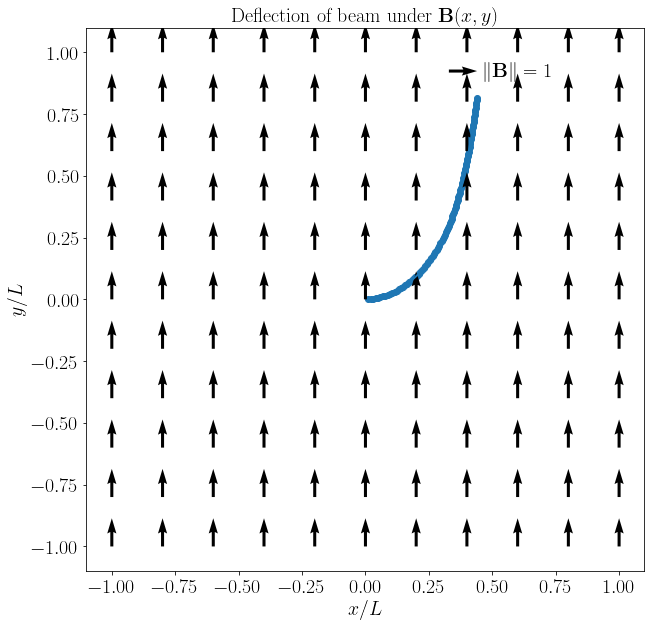

In [214]:
# Plot current configuration
from matplotlib import pyplot as plt
from matplotlib import rc

# Set up fonts
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fsize = 20

# Plot the beam
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[10, 10])
ax.plot(myBeam.X[:, 0], myBeam.X[:, 1], linewidth=2.0)
ax.scatter(myBeam.X[:, 0], myBeam.X[:, 1])
ax.set_xlabel("$x / L$", fontsize=fsize)
ax.set_ylabel("$y / L$", fontsize=fsize)
ax.set_title("Deflection of beam under $\\textbf{B}(x, y)$", fontsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize)

# Plot the Magnetic field
X = np.linspace(-1., 1., 11)
Y = np.linspace(-1., 1., 11)
XX, YY, BXX, BYY = uniformMagField.compute_B_over_grid(X, Y)
Q = ax.quiver(XX, YY, BXX, BYY, label="shit")
ax.quiverkey(Q, X=0.7, Y=0.92, U=1, label='$\|\\textbf{B}\| = 1$', labelpos='E', fontproperties={'size': fsize})
fig.show()